In [1]:
import sys 
sys.path.append("../")

import numpy as np 
from pprint import pprint
from typing import TypeVar, Iterable, Callable, Sequence
import matplotlib.pyplot as plt 
from rl.markov_process import NonTerminal, TransitionStep as TS
import itertools
from rl.markov_decision_process import FiniteMarkovDecisionProcess, TransitionStep
from rl.distribution import Choose
from rl.function_approx import LinearFunctionApprox, Weights, AdamGradient
from rl.policy import DeterministicPolicy

### Question 1: implementing LSTD algorithm from scratch

In [2]:
S = TypeVar("S")
A = TypeVar("A")

def LSTD(traces : Iterable[TS[S]], feature_functions : Sequence[Callable[[NonTerminal[S]], float]],
         gamma : float, epsilon : float) -> LinearFunctionApprox[NonTerminal[S]]:
    num_features : int = len(feature_functions)
    A_inv : np.array = np.eye(num_features)
    b_vec : np.array = np.zeros(num_features)

    for step in traces:
        state, next_state, reward = step.state, step.next_state, step.reward
        u = np.array([f(state) for f in feature_functions])
        v = u

        if isinstance(next_state, NonTerminal):
            v -= gamma * np.array([f(next_state) for f in feature_functions])

        # updating the inverse of A using Sherman-Morrison-Woodbury formula
        A_inv -= (A_inv @ np.outer(u, v) @ A_inv) / (1 + v @ A_inv @ u)
        b_vec += reward * u
    
    # find the optimal weights
    w_star : np.array = A_inv @ b_vec
    return LinearFunctionApprox.create(feature_functions=feature_functions, weights=Weights.create(w_star))

#### Testing the LSTD algorithm on an already-solved MRP

In [3]:
from rl.chapter2.simple_inventory_mrp import *

user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(capacity=user_capacity,
                                  poisson_lambda=user_poisson_lambda,
                                  holding_cost=user_holding_cost,
                                  stockout_cost=user_stockout_cost)

print("Exact Value Function:")
print("--" * 20)
si_mrp.display_value_function(gamma=user_gamma)
print()

Exact Value Function:
----------------------------------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}



In [4]:
num_episodes = 1000
num_steps = 100
epsilon = 0.01

ffs = [(lambda _ : 1.0), (lambda s : s.state.on_hand), (lambda s : s.state.on_order)]
traces = itertools.chain.from_iterable(si_mrp.reward_traces(Choose(si_mrp.non_terminal_states)))

lstd_qf = LSTD(traces=itertools.islice(traces, num_episodes * num_steps), feature_functions=ffs, gamma=user_gamma, epsilon=epsilon)

pprint({s : round(lstd_qf(s), 3) for s in si_mrp.non_terminal_states})

{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -26.735,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -31.018,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.877,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -31.055,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -28.913,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -31.091}


### Question 3: implementing LSPI for American options-pricing

In [5]:
# S = TypeVar("S")
# A = TypeVar("A")

# def LSPI(traces : Iterable[TransitionStep[S, A]], feature_functions : Sequence[Callable[[Tuple[NonTerminal[S], A]], float]],
#          gamma : float, epsilon : float) -> LinearFunctionApprox[Tuple[NonTerminal[S], A]]:
#     num_features : int = len(feature_functions)
#     A_inv : np.array = np.eye(num_features)
#     b_vec : np.array = np.zeros(num_features)
#     pol : DeterministicPolicy[S, A] = 

#     for step in traces:
#         state, action, next_state, reward = step.state, step.action, step.next_state, step.reward
#         u = np.array([f(state, action) for f in feature_functions])
#         v = u

#         if isinstance(next_state, NonTerminal):
#             v -= gamma * np.array([f(next_state, pol(next_state)) for f in feature_functions])

#         # updating the inverse of A using Sherman-Morrison-Woodbury formula
#         A_inv -= (A_inv @ np.outer(u, v) @ A_inv) / (1 + v @ A_inv @ u)
#         b_vec += reward * u

#         new_qf = 
    
#     # find the optimal weights
#     w_star : np.array = A_inv @ b_vec
#     return LinearFunctionApprox.create(feature_functions=feature_functions, weights=Weights.create(w_star))

SyntaxError: invalid syntax (128905391.py, line 9)

In [6]:
from dataclasses import dataclass, replace
from typing import Callable, Sequence, Tuple, List
import numpy as np
from scipy.stats import norm
from rl.function_approx import DNNApprox, LinearFunctionApprox, FunctionApprox, DNNSpec, AdamGradient
from random import randrange
from numpy.polynomial.laguerre import lagval

TrainingDataType = Tuple[int, float, float]


@dataclass(frozen=True)
class OptimalExerciseRL:
    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    def european_put_price(self, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        return strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - self.spot_price * norm.cdf(-d1)

    def training_sim_data(
        self,
        num_paths: int,
        spot_price_frac: float
    ) -> Sequence[TrainingDataType]:
        ret: List[TrainingDataType] = []
        dt: float = self.expiry / self.num_steps
        spot: float = self.spot_price
        vol2: float = self.vol * self.vol

        mean2: float = spot * spot
        var: float = mean2 * spot_price_frac * spot_price_frac
        log_mean: float = np.log(mean2 / np.sqrt(var + mean2))
        log_stdev: float = np.sqrt(np.log(var / mean2 + 1))

        for i in range(num_paths):
            price: float = np.random.lognormal(log_mean, log_stdev)
            for step in range(self.num_steps):
                m: float = np.log(price) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                next_price: float = np.exp(np.random.normal(m, np.sqrt(v)))
                ret.append((step, price, next_price))
                price = next_price
        return ret

    def scoring_sim_data(self, num_paths: int) -> np.ndarray:
        paths: np.ndarray = np.empty([num_paths, self.num_steps + 1])
        dt: float = self.expiry / self.num_steps
        vol2: float = self.vol * self.vol
        for i in range(num_paths):
            paths[i, 0] = self.spot_price
            for step in range(self.num_steps):
                m: float = np.log(paths[i, step]) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                paths[i, step + 1] = np.exp(np.random.normal(m, np.sqrt(v)))
        return paths


    def adam_gradient(self) -> AdamGradient:
        return AdamGradient(
            learning_rate=0.1,
            decay1=0.9,
            decay2=0.999
        )

    def linear_func_approx(
        self,
        features: Sequence[Callable[[Tuple[float, float]], float]],
        reg: float
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            adam_gradient=self.adam_gradient(),
            regularization_coeff=reg
        )

    def train_lspi(
        self,
        training_data: Sequence[TrainingDataType],
        init_fa: LinearFunctionApprox[Tuple[float, float]],
        training_iters: int,
        split: int
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        fa: LinearFunctionApprox[Tuple[float, float]] = init_fa
        dt: float = self.expiry / self.num_steps
        gamma: float = np.exp(-self.rate * dt)
        num_features: int = len(fa.feature_functions)
        states: Sequence[Tuple[float, float]] = [(i * dt, s) for
                                                 i, s, _ in training_data]
        next_states: Sequence[Tuple[float, float]] = \
            [((i + 1) * dt, s1) for i, _, s1 in training_data]
        features: np.ndarray = fa.get_feature_values(states)
        next_features: np.ndarray = fa.get_feature_values(next_states)
        non_terminal: np.ndarray = np.array(
            [i < self.num_steps - 1 for i, _, _ in training_data]
        )
        exer: np.ndarray = np.array([self.payoff(t1, s1)
                                     for t1, s1 in next_states])
        reg_mat: np.ndarray = fa.regularization_coeff * \
            np.eye(len(fa.feature_functions))
        for i in range(training_iters):
            a_mat: np.ndarray = np.zeros([num_features, num_features])
            b_vec: np.ndarray = np.zeros(num_features)
            cont: np.ndarray = fa.evaluate(next_states)
            cont_cond: np.ndarray = non_terminal * (cont > exer)
            features_split: Sequence[np.ndarray] = \
                np.array_split(features, split)
            next_features_split: Sequence[np.ndarray] = \
                np.array_split(next_features, split, axis=0)
            cont_cond_split: Sequence[np.ndarray] = \
                np.array_split(cont_cond, split)
            exer_split: Sequence[np.ndarray] = np.array_split(exer, split)
            for i in range(split):
                a_mat += features_split[i].T.dot(
                    features_split[i] - np.diag(cont_cond_split[i]).dot(
                        next_features_split[i] * gamma
                    )
                )
                b_vec += features_split[i].T.dot(
                    (1 - cont_cond_split[i]) * exer_split[i] * gamma
                )
            a_mat /= len(training_data)
            a_mat += reg_mat
            b_vec /= len(training_data)
            wts: np.ndarray = np.linalg.solve(a_mat, b_vec)
            fa = replace(
                fa,
                weights=replace(
                    fa.weights,
                    weights=wts
                )
            )
        return fa


    def continuation_curve(
        self,
        func: FunctionApprox[Tuple[float, float]],
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return func.evaluate([(t, p) for p in prices])

    def exercise_curve(
        self,
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return np.array([self.payoff(t, p) for p in prices])

    def put_option_exercise_boundary(
        self,
        func: FunctionApprox[Tuple[float, float]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for step in range(self.num_steps):
            cp: np.ndarray = self.continuation_curve(
                func=func,
                step=step,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(step=step, prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(self.expiry, p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret

    def option_price(
        self,
        scoring_data: np.ndarray,
        func: FunctionApprox[Tuple[float, float]]
    ) -> float:
        num_paths: int = scoring_data.shape[0]
        prices: np.ndarray = np.zeros(num_paths)
        dt: float = self.expiry / self.num_steps

        for i, path in enumerate(scoring_data):
            step: int = 0
            while step <= self.num_steps:
                t: float = step * dt
                exercise_price: float = self.payoff(t, path[step])
                continue_price: float = func.evaluate([(t, path[step])])[0] \
                    if step < self.num_steps else 0.
                step += 1
                if exercise_price >= continue_price:
                    prices[i] = np.exp(-self.rate * t) * exercise_price
                    step = self.num_steps + 1

        return np.average(prices)


def fitted_lspi_put_option(
    obj: OptimalExerciseRL,
    strike: float,
    expiry: float,
    training_data: Sequence[TrainingDataType],
    training_iters: int,
    split: int
) -> LinearFunctionApprox[Tuple[float, float]]:

    num_laguerre: int = 3
    lspi_reg: float = 0.001

    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float]], float]] = [lambda _: 1.]
    features += [(lambda t_s, i=i: np.exp(-t_s[1] / (2 * strike)) *
                  lagval(t_s[1] / strike, ident[i]))
                 for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    linear_approx: LinearFunctionApprox[Tuple[float, float]] = \
        obj.linear_func_approx(features=features, reg=lspi_reg)

    return obj.train_lspi(
        training_data=training_data,
        init_fa=linear_approx,
        training_iters=training_iters,
        split=split
    )

### Testing the above algorithm for the American-option pricing:

European Price = 7.459
Generated Training Data
Fitted LSPI Model


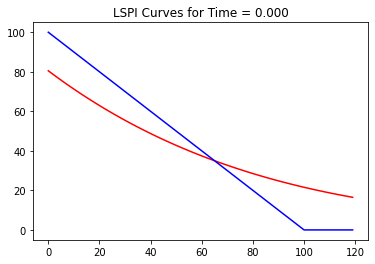

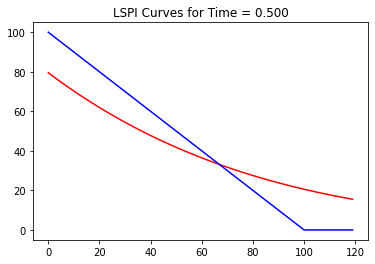

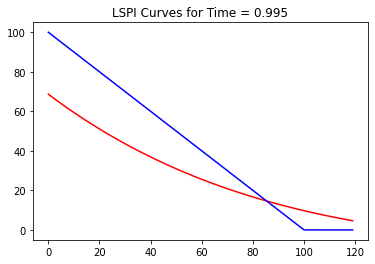

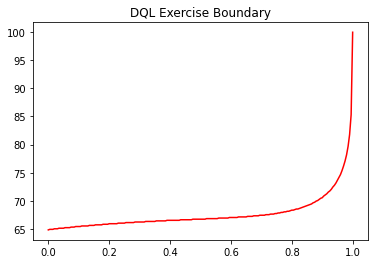

LSPI Option Price = 7.721


In [8]:
# ffs = [(lambda _ : 1.0), (lambda x : np.exp(-0.5 * x.moneyness)), 
#        (lambda x : np.exp(-0.5 * x.moneyness) * (1 - x)), 
#        (lambda x : np.exp(-0.5 * x.moneyness) * (1 - 2 * x.moneyness + 0.5 * x.moneyness ** 2)),
#        (lambda x : np.sin(np.pi * (x.T - x.time) / (2 * x.T))),
#        (lambda x : np.log(x.T - x.time)),
#        (lambda x : (x.time / x.T) ** 2)]

import matplotlib.pyplot as plt
spot_price_val: float = 100.0
strike: float = 100.0
expiry_val: float = 1.0
rate_val: float = 0.05
vol_val: float = 0.25
num_steps_val: int = 200

dt: float = expiry_val / num_steps_val

num_training_paths: int = 5000
spot_price_frac_val: float = 0.0

dql_training_iters: int = 1000000
lspi_training_iters: int = 8

split_val: int = 1000

num_scoring_paths: int = 10000

def payoff_func(_: float, s: float) -> float:
    return max(strike - s, 0.)

opt_ex_rl: OptimalExerciseRL = OptimalExerciseRL(
    spot_price=spot_price_val,
    payoff=payoff_func,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

european_price: float = opt_ex_rl.european_put_price(strike)
print(f"European Price = {european_price:.3f}")

training_data: Sequence[TrainingDataType] = opt_ex_rl.training_sim_data(
    num_paths=num_training_paths,
    spot_price_frac=spot_price_frac_val
)
print("Generated Training Data")

flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    obj=opt_ex_rl,
    strike=strike,
    expiry=expiry_val,
    training_data=training_data,
    training_iters=lspi_training_iters,
    split=split_val
)

print("Fitted LSPI Model")

for step in [0, int(num_steps_val / 2), num_steps_val - 1]:
    prices: np.ndarray = np.arange(120.0)
    exer_curve: np.ndarray = opt_ex_rl.exercise_curve(
        step=step,
        prices=prices
    )
    cont_curve_lspi: np.ndarray = opt_ex_rl.continuation_curve(
        func=flspi,
        step=step,
        prices=prices
    )
    plt.plot(
        prices,
        cont_curve_lspi,
        "r",
        prices,
        exer_curve,
        "b"
    )
    time: float = step * expiry_val / num_steps_val
    plt.title(f"LSPI Curves for Time = {time:.3f}")
    plt.show()

ex_boundary_lspi: Sequence[float] = opt_ex_rl.put_option_exercise_boundary(
    func=flspi,
    strike=strike
)
time_pts: Sequence[float] = [i * dt for i in range(num_steps_val + 1)]
plt.plot(time_pts, ex_boundary_lspi, "r")
plt.title("LSPI Exercise Boundary")
plt.show()

scoring_data: np.ndarray = opt_ex_rl.scoring_sim_data(
    num_paths=num_scoring_paths
)

lspi_opt_price: float = opt_ex_rl.option_price(
    scoring_data=scoring_data,
    func=flspi
)
print(f"LSPI Option Price = {lspi_opt_price:.3f}")